In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [34]:
path = r"C:\Valeriia\py-restaurant-data-analysis\db.sqlite3"
conn = sqlite3.connect(path)
sql_query = '''
SELECT  order_id, datetime, product_id, quantity, name, price
FROM
    restaurant_orderitem as r
JOIN
    restaurant_order as o ON r.order_id = o.id
JOIN
    restaurant_product as p ON r.product_id = p.id;
'''
data = pd.read_sql_query(sql_query, conn)
data.to_csv("data.csv", index=False)
conn.close()
df = pd.read_csv("data.csv")
df.shape[0]

74818

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

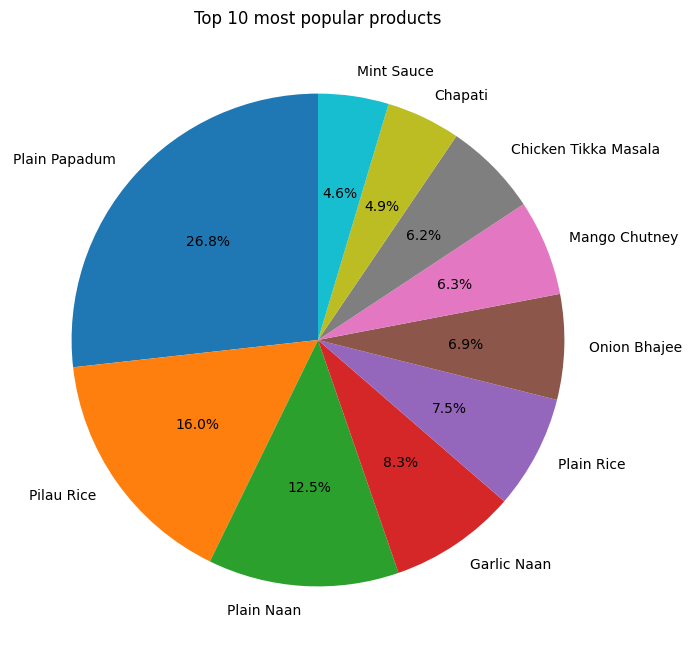

In [32]:
products = df.groupby("name")["quantity"].sum()
top10 = products.nlargest(10, "all")
plt.figure(figsize=(8, 8))
plt.pie(top10, labels=top10.index, autopct="%1.1f%%", startangle=90)
plt.title("Top 10 most popular products")
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 
10) make the most money for restaurant. It should be also with percentage.

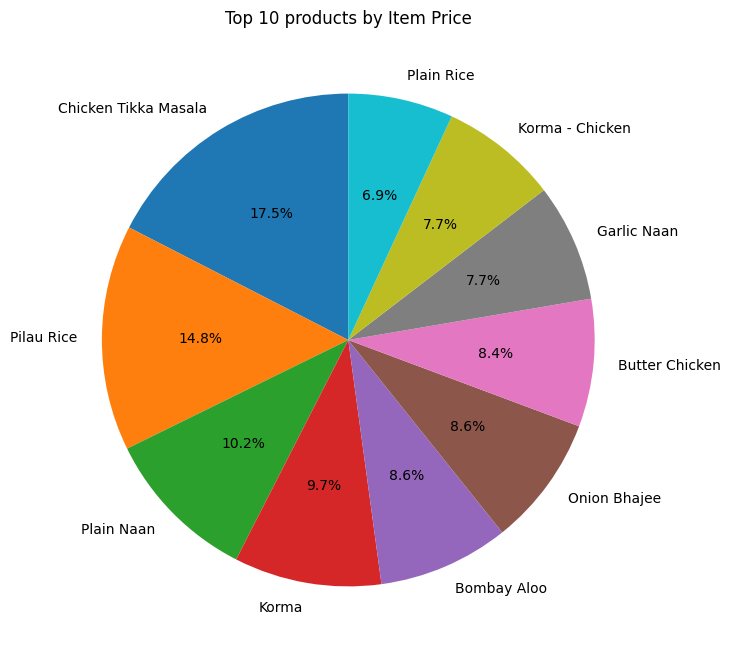

In [31]:
df["Item Price"] = df["price"] * df["quantity"]
orders = df.groupby("name")["Item Price"].sum()
top10 = orders.nlargest(10, "all")

plt.figure(figsize=(8, 8))
plt.pie(top10, labels=top10.index, autopct="%1.1f%%", startangle=90)
plt.title("Top 10 products by Item Price")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

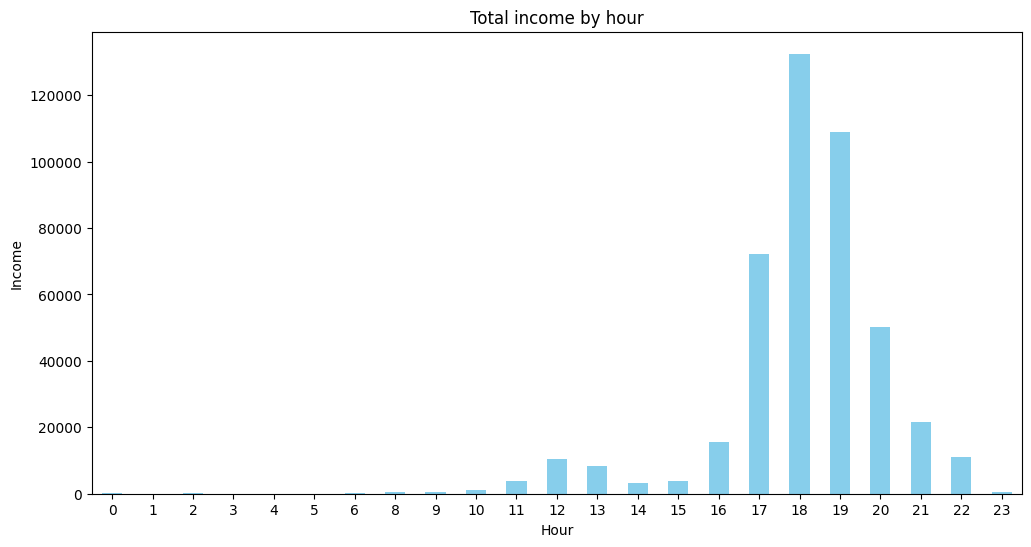

In [30]:
df["Order Datetime"] = pd.to_datetime(df["datetime"])
df["Order Hour"] = df["Order Datetime"].dt.hour
hours = df.groupby("Order Hour")["Item Price"].sum()

plt.figure(figsize=(12, 6))
hours.plot(kind="bar", color="skyblue")
plt.xlabel("Hour")
plt.ylabel("Income")
plt.title("Total income by hour")
plt.xticks(rotation=0)
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

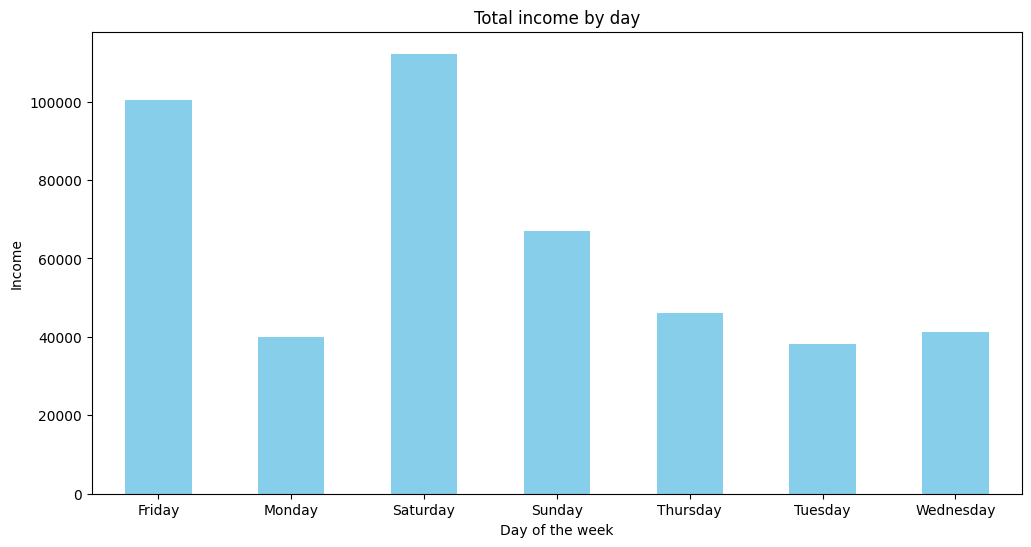

In [29]:
df["Order Day"] = df["Order Datetime"].dt.day_name()
hours = df.groupby("Order Day")["Item Price"].sum()

plt.figure(figsize=(12, 6))
hours.plot(kind="bar", color="skyblue")
plt.xlabel("Day of the week")
plt.ylabel("Income")
plt.title("Total income by day")
plt.xticks(rotation=0)
plt.show()